In [1]:
import numpy as np
import itertools

import jax
import jax.numpy as jnp

# -------------- helper libraries -------------- #
import sys
import os
import time
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import importlib

def append_path(path):
    if path not in sys.path:
        sys.path.append(path)
        
append_path(os.path.abspath(os.path.join('..', '00_utils')))
append_path(os.path.abspath(os.path.join('..', '00_utils_training')))
append_path(os.path.abspath(os.path.join('..', '00_models')))

import collocation_obj
import run_train_toy

import logging
logging.basicConfig(level=logging.ERROR, filename='error_log.txt')

In [2]:
importlib.reload(collocation_obj)
Collocation = collocation_obj.Collocation

### Set Out Hyperparameter Optimization (Shared Parameters)
* network size
* regularization
* number of training points

### Pyomo-specific Hyperparameters
* number of collocation points with fixed n. of training points
* objective tolerances

### Sequential ODE Solver Hyperparameters
* learning rate
* number of training epochs
* ODE-solver tolerances


---
# Generate Data

In [9]:
importlib.reload(run_train_toy)
TrainerToy = run_train_toy.TrainerToy

def load_trainer(type_, spacing_type="chebyshev", detailed = False):
    data_params_ho = {
        'N': 200,
        'noise_level': 0.2,
        'ode_type': "harmonic_oscillator",
        'data_param': {"omega_squared": 2},
        'start_time': 0,
        'end_time': 10,
        'spacing_type': spacing_type,
        'initial_state': np.array([0.0, 1.0]),
        'detailed': detailed
    }

    data_params_vdp = {
        'N': 200,
        'noise_level': 0.3,
        'ode_type': "van_der_pol",
        'data_param': {"mu": 1, "omega": 1},
        'start_time': 0,
        'end_time': 15,
        'spacing_type': spacing_type,
        'initial_state': np.array([0.0, 1.0]),
        'detailed' : detailed
    }

    data_params_do = {
        'N': 200,
        'noise_level': 0.1,
        'ode_type': "damped_oscillation",
        'data_param': {"damping_factor": 0.1, "omega_squared": 1},
        'start_time': 0,
        'end_time': 10,
        'spacing_type': spacing_type,
        'initial_state': np.array([0.0, 1.0]),
        'detailed' : detailed
    }

    if type_ == "ho":
        p_ = data_params_ho
    elif type_ == "vdp":
        p_ = data_params_vdp
    elif type_ == "do":
        p_ = data_params_do
    else:
        raise ValueError(f"Invalid type {type_}")

    trainer = TrainerToy(p_, model_type="pyomo")
    trainer.prepare_inputs()
    return trainer

## Visualize Synthetic Data

In [10]:
trainer_ch = load_trainer("vdp")
print('-----')
trainer_gl = load_trainer("vdp", 'gauss_legendre')

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


-----


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


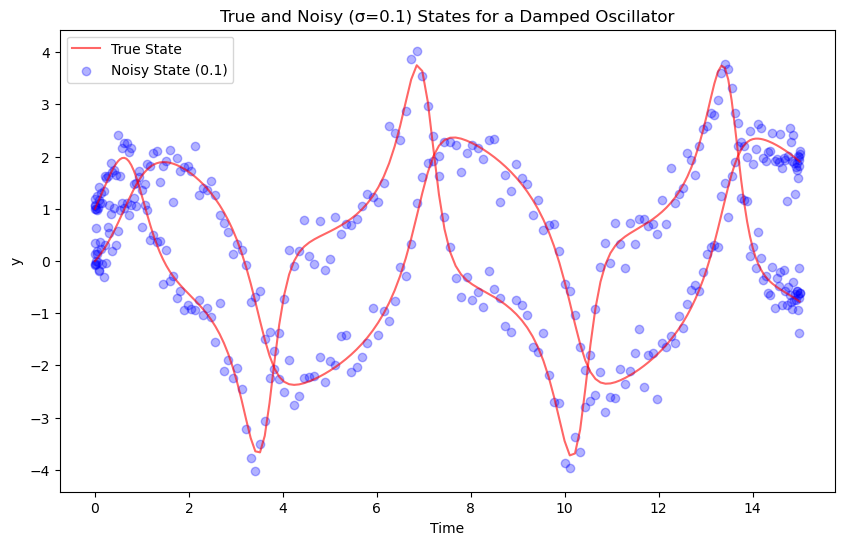

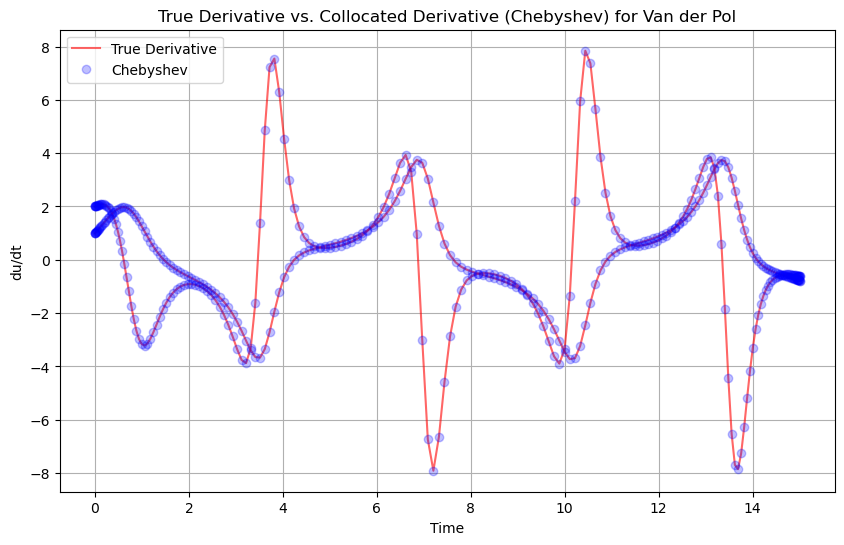

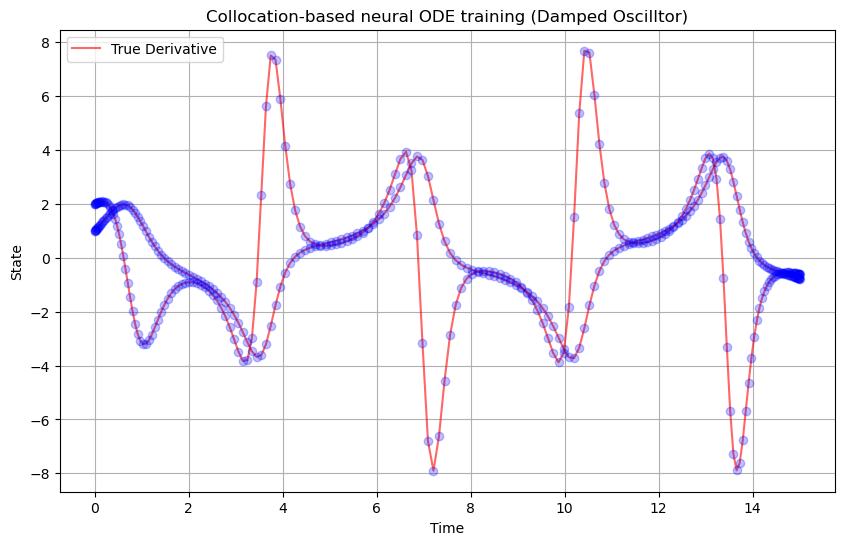

In [11]:
k = 200
D = trainer_ch.D

plt.figure(figsize=(10, 6))

plt.plot(trainer_ch.t, trainer_ch.y[:,0], color = 'red', alpha = 0.6, label = 'True State')
plt.plot(trainer_ch.t, trainer_ch.y[:,1], color = 'red', alpha = 0.6)
plt.scatter(trainer_ch.t, trainer_ch.y_noisy[:,0], color = 'blue', alpha = 0.3, label = 'Noisy State (0.1)')
plt.scatter(trainer_ch.t, trainer_ch.y_noisy[:,1], color = 'blue', alpha = 0.3)

plt.title("True and Noisy (σ=0.1) States for a Damped Oscillator")
plt.xlabel("Time")
plt.ylabel("y")
plt.legend(loc ="upper left")
plt.grid(False)
plt.show()

dy_dt_0 = []
dy_dt_1 = []

for i in range(len(trainer_ch.t)):
    dy_dt = (D[i] @ trainer_ch.y)
    dy_dt_0.append(dy_dt[0])
    dy_dt_1.append(dy_dt[1])

plt.figure(figsize=(10, 6))

plt.plot(trainer_ch.t, trainer_ch.true_derivative[:,0], color = 'red', alpha = 0.6, label = 'True Derivative')
plt.plot(trainer_ch.t, trainer_ch.true_derivative[:,1], color = 'red', alpha = 0.6)
plt.plot(trainer_ch.t[:k], dy_dt_0[:k], 'o', color = 'blue', alpha = 0.25, label = 'Chebyshev')
plt.plot(trainer_ch.t[:k], dy_dt_1[:k], 'o', color = 'blue', alpha = 0.25)

plt.title(f"True Derivative vs. Collocated Derivative (Chebyshev) for Van der Pol")
plt.xlabel("Time")
plt.ylabel("du/dt")
plt.legend(loc ="upper left")
plt.grid(True)
plt.show()

D = trainer_gl.D

dy_dt_0 = []
dy_dt_1 = []

for i in range(len(trainer_gl.t)):
    dy_dt = (D[i] @ trainer_gl.y)
    dy_dt_0.append(dy_dt[0])
    dy_dt_1.append(dy_dt[1])
    
k = 200
plt.figure(figsize=(10, 6))

plt.plot(trainer_gl.t, trainer_gl.true_derivative[:,0], color = 'red', alpha = 0.6, label = 'True Derivative')
plt.plot(trainer_gl.t, trainer_gl.true_derivative[:,1], color = 'red', alpha = 0.6)
plt.plot(trainer_gl.t[:k], dy_dt_0[:k], 'o',color = 'blue', alpha = 0.25)
plt.plot(trainer_gl.t[:k], dy_dt_1[:k], 'o',color = 'blue', alpha = 0.25)

plt.title(f"Collocation-based neural ODE training (Damped Oscilltor)")
plt.xlabel("Time")
plt.ylabel("State")
plt.legend(loc ="upper left")
plt.grid(True)
plt.show()

## Hyperparameter Optimization

#### Regularization [X]
#### Pre-initalization [X]
#### Tolerances [X]
#### Network Sizes [X]

In [46]:
def extract_metrics(results_dict):
    time_elapsed, mse_train, mse_test = [], [], []
    for key, value in results_dict.items():
        time_elapsed.append(value['time_elapsed'])
        mse_train.append(value['mse_train'].item())
        mse_test.append(value['mse_test'].item())
    return time_elapsed, mse_train, mse_test

In [47]:
tol_list = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
param_combinations = list(itertools.product(tol_list, tol_list))

In [51]:
def run(optimization_type):
  tol = 1e-4
  params_model = {
      'layer_widths': [2, 32, 2],
      'act_func': 'tanh',
      'penalty_lambda_reg': 0.001,
      'time_invariant': True,
      'w_init_method': 'xavier',
      "reg_norm": False,
      "skip_collocation": np.inf,
      'params': 
              {
            "tol":tol, 
            "print_level": 1, 
            "max_iter": 3000}}

  TRAINER = load_trainer("do")
  RESULTS = {}
  REPEATS = 1

  if optimization_type == 'regularization':
    param_combinations = [1e-6, 0.0001, 0.01, 0.1, 1]
    
  elif optimization_type == 'tolerances':
    tol_list = [1, 1e-1, 1e-2, 1e-4, 1e-6, 1e-8]
    param_combinations = list(itertools.product(tol_list, tol_list))
    
  elif optimization_type == 'reg_tol': 
    reg_list = [0.001, 0.01, 0.1]
    tol_list = [1e-6, 1e-7, 1e-8]
    param_combinations = list(itertools.product(reg_list, tol_list))
    
  elif optimization_type == 'skip_collocation':
    param_combinations = [np.inf, 25, 10, 5, 2, 1]
    
  elif optimization_type == 'training_convergence':
    data = ['ho', 'vdp', 'do']
    pre_initialize = [True]
    l = np.array([i for i in range(1, 100)]) # must be the last
    param_combinations = list(itertools.product(data, pre_initialize, l))
    tested_params = []
    
  elif optimization_type == 'network_size_grid_search':
    lw_list = [[2, 8, 2], [2, 16, 2], [2, 32, 2], [2, 64, 2], [2, 128, 2]]
    reg_list = [0.0001, 0.001, 0.01]
    tol_list = [1e-4, 1e-6]
    param_combinations = list(itertools.product(lw_list, reg_list, tol_list))
    
  elif optimization_type == 'activation_function':
    act_func_list = ['tanh', 'softplus', 'sigmoid']
    data = ['ho', 'vdp', 'do']
    param_combinations = list(itertools.product(act_func_list, data))
    
  elif optimization_type == 'weights_init':
    weights_init_list = ['xavier', 'he', 'random']
    data = ['ho', 'vdp', 'do']
    param_combinations = list(itertools.product(weights_init_list, data))
  
  elif optimization_type == 'none':
    param_combinations = [0]  
  
  else:
    raise ValueError(f"Invalid optimization type {optimization_type}")
      
  total_iter = len(param_combinations)
  i = 1

  for param_comb in param_combinations:
      # PARAMETER UPDATE
      if optimization_type == 'regularization':
          params_model['penalty_lambda_reg'] = param_comb
      elif optimization_type == 'tolerances': 
          params_model['params']['tol'] = param_comb[0]
          params_model['params']['constr_viol_tol'] = param_comb[1]
          params_model['params']['compl_inf_tol'] = param_comb[1]
          params_model['params']['dual_inf_tol'] = param_comb[1]
              
      elif optimization_type == 'skip_collocation':
          params_model['skip_collocation'] = param_comb
          
      elif optimization_type == 'training_convergence':
          params_model['params']['max_iter'] = param_comb[2]
          
          if param_comb[2] == 1:
            TRAINER = load_trainer(param_comb[0])
            params_model['pre_initialize'] = param_comb[1]
            tested_params = []
          
          if (param_comb[0],param_comb[1]) in tested_params:
            continue
            
      elif optimization_type == 'network_size_grid_search':
          params_model['layer_widths'] = param_comb[0]
          params_model['penalty_lambda_reg'] = param_comb[1]
          params_model['params']['tol'] = param_comb[2]
          
      elif optimization_type == 'activation_function':
          params_model['act_func'] = param_comb[0]
          TRAINER = load_trainer(param_comb[1])
          
      elif optimization_type == 'weights_init':
          params_model['w_init_method'] = param_comb[0]
          TRAINER = load_trainer(param_comb[1])
      
      elif optimization_type == 'none':
          params_model['pre_initialize'] = True
          
      try:
        TRAINER.train_pyomo(params_model)
        if optimization_type == 'training_convergence' and 'optimal' in TRAINER.termination:
          print(f"Optimal solution found at/before iteration {param_comb}")
          tested_params.append((param_comb[0], param_comb[1]))
      except Exception as e:
        RESULTS[param_comb] = {'time_elapsed': np.array(np.nan), 'mse_train': np.array(np.nan), 'mse_test': np.array(np.nan)}
        logging.error("Failed to complete training: {}".format(e))
        print(f"{e}")
        continue
      
      try:
        if optimization_type == 'network_size_grid_search':
          k = (param_comb[0][1], param_comb[1], param_comb[2])
          RESULTS[k] = TRAINER.extract_results_pyomo()
        else:
          RESULTS[param_comb] = TRAINER.extract_results_pyomo()
      except Exception as e:
        RESULTS[param_comb] = {'time_elapsed': np.array(np.nan), 'mse_train': np.array(np.nan), 'mse_test': np.array(np.nan)}
        logging.error("Failed to extract results: {}".format(e))
        print(f"{e}")
      
      print("Iteration:", i, "/", total_iter)
      i+=1
      
  return RESULTS, TRAINER

In [52]:
importlib.reload(run_train_toy)
TrainerToy = run_train_toy.TrainerToy

results, trainer = run('activation_function')

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")
/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


current_16_08


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:86: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=0.0001
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.7475049495697021, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 1 / 9


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


current_16_08


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:86: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=0.0001
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 7.807482719421387, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 2 / 9


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


current_16_08


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:86: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=0.0001
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.075079917907715, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 3 / 9


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


current_16_08


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:86: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=0.0001
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.2961671352386475, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 4 / 9


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


current_16_08


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:86: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=0.0001
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 4.810935974121094, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 5 / 9


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


current_16_08


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:86: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=0.0001
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.659393072128296, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 6 / 9


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


current_16_08


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:86: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=0.0001
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.4107911586761475, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 7 / 9


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


current_16_08


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:86: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=0.0001
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 6.068875074386597, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 8 / 9


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


current_16_08


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:86: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=0.0001
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.5435919761657715, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 9 / 9


In [53]:
results

{('tanh', 'ho'): {'time_elapsed': 1.7475049495697021,
  'mse_train': Array(0.00577944, dtype=float64),
  'mse_test': Array(0.0034757, dtype=float64),
  'termination': <TerminationCondition.optimal: 'optimal'>},
 ('tanh', 'vdp'): {'time_elapsed': 7.807482719421387,
  'mse_train': Array(0.02190402, dtype=float64),
  'mse_test': Array(0.61204147, dtype=float64),
  'termination': <TerminationCondition.optimal: 'optimal'>},
 ('tanh', 'do'): {'time_elapsed': 2.075079917907715,
  'mse_train': Array(0.00114093, dtype=float64),
  'mse_test': Array(0.00328842, dtype=float64),
  'termination': <TerminationCondition.optimal: 'optimal'>},
 ('softplus', 'ho'): {'time_elapsed': 2.2961671352386475,
  'mse_train': Array(0.21263089, dtype=float64),
  'mse_test': Array(0.39152504, dtype=float64),
  'termination': <TerminationCondition.optimal: 'optimal'>},
 ('softplus', 'vdp'): {'time_elapsed': 4.810935974121094,
  'mse_train': Array(2.58395821, dtype=float64),
  'mse_test': Array(3.6260246, dtype=float6

In [32]:
reload = False
if reload:
    formatted_time = time.strftime('%Y-%m-%d_%H-%M-%S')
    filename = f'results/pyomo_training_convergence_all_new.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(results, file)
    print(f"Results saved to {filename}")

In [33]:
reload = False
if reload:
    formatted_time = time.strftime('%Y-%m-%d_%H-%M-%S')
    filename = f'results/{formatted_time}_training.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(results, file)

---

## Vizualize Predictions

In [41]:
full_results = trainer.extract_results_pyomo(True)

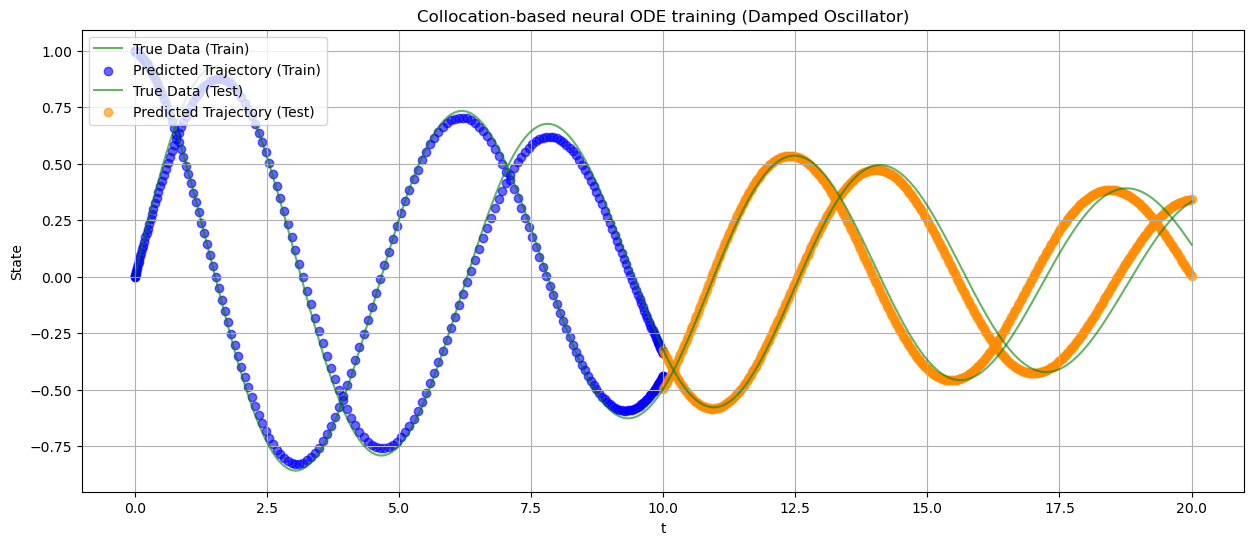

In [42]:
y_pred = full_results['odeint_pred']
y_pred_test = full_results['odeint_pred_test']

plt.figure(figsize=(15, 6))

plt.plot(trainer.t, trainer.y[:,0], color = 'green', label='True Data (Train)', alpha = 0.6)
plt.plot(trainer.t, trainer.y[:,1], color = 'green', alpha = 0.6)
plt.scatter(trainer.t, y_pred[:,0], color = 'blue', label='Predicted Trajectory (Train)', alpha = 0.6)
plt.scatter(trainer.t, y_pred[:,1], color = 'blue', alpha = 0.6)

plt.plot(trainer.t_test, trainer.y_test[:,0], color='green', label='True Data (Test)', alpha = 0.6)
plt.plot(trainer.t_test, trainer.y_test[:,1], color='green', alpha = 0.6)
plt.scatter(trainer.t_test, y_pred_test[:,0], color='#FF8C00', label='Predicted Trajectory (Test)', alpha = 0.6)
plt.scatter(trainer.t_test, y_pred_test[:,1], color='#FF8C00', alpha = 0.6)

plt.title(f"Collocation-based neural ODE training (Damped Oscillator)")
plt.xlabel("t")
plt.ylabel("State")
plt.legend(loc ="upper left")
plt.grid(True)
plt.show()

----